In [1]:
from SimPEG import EM, Survey
from SimPEG import Mesh, Utils
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEMIP.TDEM import Problem3D_e
%pylab inline
cs = 40.
npad = 5
hx = [(cs, npad, -1.3), (cs, 21), (cs, npad, 1.3)]
hy = [(cs, npad, -1.3), (cs, 21), (cs, npad, 1.3)]
hz = [(cs, npad, -1.3), (cs, 20), (cs, npad, 1.3)]
mesh = Mesh.TensorMesh([hx, hy, hz], x0="CCC")
sigma = np.ones(mesh.nC)*1e-2
airind = mesh.gridCC[:,2] > 0.
sigma[airind] = 1e-2

x = mesh.vectorCCx[(mesh.vectorCCx > -155.) & (mesh.vectorCCx < 155.)]
y = mesh.vectorCCx[(mesh.vectorCCy > -155.) & (mesh.vectorCCy < 155.)]

Aloc = np.r_[-20., 0., 0.]
Bloc = np.r_[20., 0., 0.]
# M = Utils.ndgrid(x-25., y, np.r_[0.])
# N = Utils.ndgrid(x+25., y, np.r_[0.])
# rxloc = Utils.ndgrid(x, y, np.r_[0.])
rxloc = np.r_[300., 0., 0.].reshape([1, -1])
srcloc = np.vstack((Aloc, Bloc))

Populating the interactive namespace from numpy and matplotlib


In [2]:
tmax = 1e-3
tmin = 1e-4
print 1200*np.sqrt(100*tmin) / 3.
print 1200*np.sqrt(100*tmax) 
print mesh.hx[:10].sum()

40.0
379.47331922
670.2412


In [3]:
times = np.logspace(-4, -3, 21)
rx = EM.TDEM.Rx.Point_e(rxloc, times, orientation='x')
src = EM.TDEM.Src.LineCurrent([rx], loc=srcloc, waveform = EM.TDEM.Src.StepOffWaveform())

In [4]:
eta = np.ones_like(sigma) * 0.2
# eta[airind] = 0.
tau = np.ones_like(sigma) * 0.1
c = np.ones_like(sigma) * 0.5

prb = Problem3D_e(mesh, sigmaInf = sigma, eta=eta, tau=tau, c=c, verbose=True)
# prb = EM.TDEM.Problem3D_e(mesh, sigma=sigma, verbose=True)
prb.Solver = PardisoSolver
prb.solverOpts = {"is_symmetric":False}
# prb.timeSteps = [(1e-4, 10), (5e-4, 10), (1e-3, 10)]
prb.timeSteps = [(1e-4, 15)]

In [5]:
survey = EM.TDEM.Survey([src])
survey.pair(prb)

In [6]:
f = prb.fields(sigma)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:354: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


Calculating Initial fields
Factorize system matrix for DC problem


/Users/sgkang/Projects/simpegemip/simpegEMIP/TDEM/ProblemTDEMIP.py:230: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tn = self.times[n]


**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-04)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
**************************************************
Done calculating fields(m)
**************************************************


In [12]:
dpred = survey.dpred(sigma, f=f)

In [13]:
from simpegem1d import DigFilter

In [14]:
from em_examples import FDEMDipolarfields
wt, tbase, omega_int = DigFilter.setFrequency(rx.times)
frequency = omega_int/np.pi/2.
def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))
sigma = ColeColeSeigel(frequency, 1e-2, 0.2, 0.1, 0.5)
anax, anay, anaz = FDEMDipolarfields.E_from_ElectricDipoleWholeSpace(rxloc, np.r_[0, 0, 0], sigma, frequency, orientation="X", length=40.)
out = DigFilter.transFilt(anax, wt, tbase, omega_int, rx.times)

In [15]:
from em_examples import TDEMDipolarfields
anax_temp, anay, anaz = TDEMDipolarfields.E_from_ElectricDipoleWholeSpace(rxloc, np.r_[0, 0, 0], 0.01, rx.times, orientation="X", length=40.)

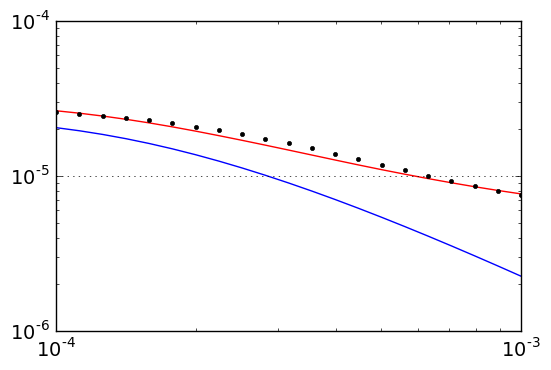

In [16]:
plt.loglog(rx.times, anax_temp, 'b-')
plt.loglog(rx.times, out[0], 'r-')
plt.loglog(rx.times, dpred, 'k.')
plt.grid(True)